# 2x Single-Image Super-Resolution on Grayscale Images

**Assignment:** Individual Class Project<br>
**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Using small-sized grayscale images, construct a CNN-based architecture that will downscale (magnify) the images by a factor of 2.<br>
**Emphasis:** Describe the concept of single-image super-resolution, describe the architecture in sufficient detail and show indicative training and post-training results.<br>


**References:**
* https://www.kaggle.com/spaceengineer1/alexonly-greyscale
* https://www.kaggle.com/c/two-sigma-financial-news/discussion/83593
* https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

In [132]:
# Imports
import os.path
import random
import shutil
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [133]:
# Constants
RANDRANGE_STOP=10000
EPOCHS = 100
BATCH_SIZE = 10
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
IMAGE_EXTENSION = 'jpg'
PROCESSED_IMAGE_FOLDER ='dataSet'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
RESCALE_FACTOR = 1./255
VALIDATION_SPLIT = 0.2
CHANNELS = 1
ORIG_IMG_SIZE = 64
UPSCALE_FACTOR = 2
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

## Prepocessing

In [134]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    trainDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(trainDirPre):
        shutil.move(trainDirPre, '.')
        
    return topDir

In [135]:
# Pre Process Images
imgFolder = DownloadImageSet()

In [136]:
def ImageNorm(image):
    image = image/255.0
    return image

In [137]:
def Shrink(image):
    return tf.image.resize(image,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [138]:
trainSet = image_dataset_from_directory(
    directory=imgFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


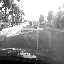

In [139]:
for batch in trainSet.take(1):
    display(array_to_img(batch[0]))

In [140]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [141]:
valSet = image_dataset_from_directory(
    directory=imgFolder,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [142]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Create Model

In [143]:
def SuperResolution():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=CHANNELS * LOW_RES_IMG_SIZE^2, kernel_size=9, activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=1, activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(filters=CHANNELS * ORIG_IMG_SIZE^2, kernel_size=5, activation='relu', padding='same'))
    return model

In [144]:
sr = SuperResolution()
srOpt = keras.optimizers.SGD(learning_rate=0.001)
srLossFn = keras.losses.MeanSquaredError()
sr.compile(optimizer=srOpt, loss=srLossFn)

In [145]:
sr.fit(trainSet, epochs=EPOCHS, validation_data=valSet, verbose=1)

Epoch 1/100


ValueError: in user code:

    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10250 squared_difference
        "SquaredDifference", x=x, y=y, name=name)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\func_graph.py:592 _create_op_internal
        compute_device)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\ops.py:3536 _create_op_internal
        op_def=op_def)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\ops.py:2016 __init__
        control_input_ops, op_def)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 32 and 64 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_8/conv2d_26/Relu, IteratorGetNext:1)' with input shapes: [?,32,32,66], [?,64,64,3].
